# SOUND SIGNAL CLASSIFICATION USING DEEP LEARNING

This project consists of 3 main steps:

1. Step We will prepare our dataset for analysis and extract sound signal features from  audio files using Mel-Frequency Cepstral Coefficients(MFCC).

2. Then we will build a Convolutional Neural Networks (CNN) model and train our model with our dataset. 

3. Finally we predict an audio file's class using our model.

We will use UrbanSound8K Dataset, download Link is here: https://urbansounddataset.weebly.com/download-urbansound8k.html
    

In [1]:
import tensorflow as tf 
import matplotlib.pyplot as plt
import pandas as pd
import os
import librosa
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense,Dropout,Activation,Flatten
from keras.optimizers import Adam
from sklearn import metrics
from keras.callbacks import ModelCheckpoint
from datetime import datetime 
import warnings
warnings.filterwarnings('ignore')

In [2]:
audio_file_path='UrbanSound8K/17973-2-0-32.wav'

librosa_audio_data, librosa_sample_rate = librosa.load(audio_file_path)

In [3]:
# An important thing you should know about librosa is librosa converts any stereo signal into mono. 
# So librosa converted signal data is one dimensional since it converts all signals into mono and get 
# signal characteristics of your sound file over this mono signal form..
print(librosa_audio_data)

[ 0.0591024   0.04647241 -0.02115159 ... -0.0069612   0.03259261
  0.09148587]


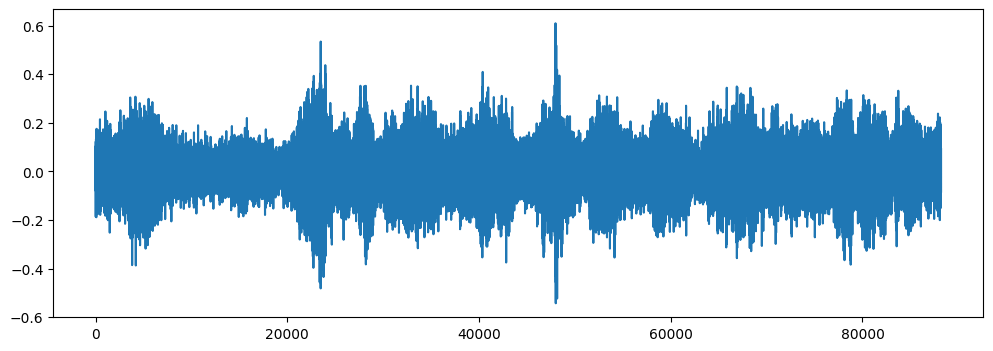

In [4]:
plt.figure(figsize=(12, 4))
plt.plot(librosa_audio_data)
plt.show()

In [5]:
# Lets read with scipy
from scipy.io import wavfile as wav
wave_sample_rate, wave_audio = wav.read(audio_file_path)

In [6]:
# Stereo 
wave_audio

array([[2189, 3314],
       [1592, 2598],
       [ 848, 1712],
       ...,
       [1326, 2602],
       [1915, 3542],
       [2542, 4449]], dtype=int16)

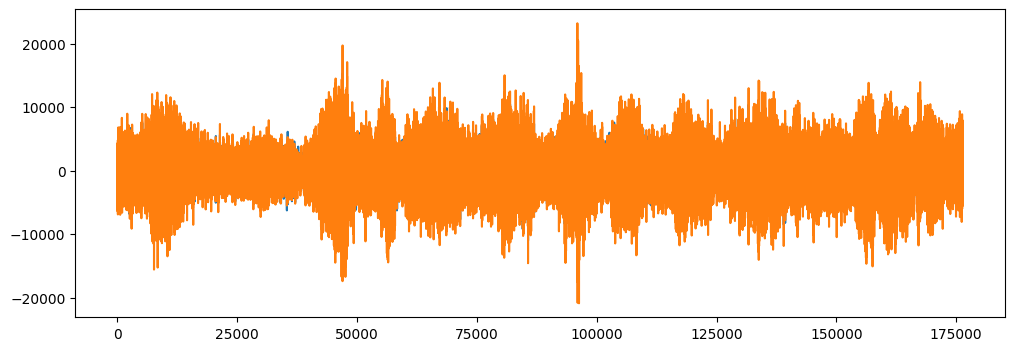

In [7]:
# Original audio with 2 channels 
plt.figure(figsize=(12, 4))
plt.plot(wave_audio)
plt.show()

### Feature Extraction

Here we will be using Mel-Frequency Cepstral Coefficients(MFCC) from the audio samples. The MFCC summarises the frequency distribution across the window size, so it is possible to analyse both the frequency and time characteristics of the sound. These audio representations will allow us to identify features for classification.


In [8]:
mfccs = librosa.feature.mfcc(y=librosa_audio_data, sr=librosa_sample_rate, n_mfcc=40)   #n_mfcc: number of MFCCs to return 
print(mfccs.shape)

(40, 173)


In [9]:
mfccs

array([[-166.06232  , -151.50266  , -172.7387   , ..., -192.53252  ,
        -179.10658  , -179.59177  ],
       [  75.67847  ,   93.39499  ,  109.314476 , ...,  107.66586  ,
          87.26424  ,   67.258606 ],
       [-107.505295 , -118.782585 , -128.7536   , ..., -112.772415 ,
         -97.96594  ,  -85.718735 ],
       ...,
       [  -9.79513  ,   -8.940213 ,  -14.132216 , ...,   -6.595045 ,
          -2.1138763,   -5.7154026],
       [   5.047469 ,    3.61415  ,    5.1923423, ...,   -4.643527 ,
         -11.839522 ,  -17.177223 ],
       [   4.929694 ,    7.5509963,    7.0431576, ...,   -2.6938524,
          -6.5428867,   -7.347314 ]], dtype=float32)

In [10]:
# We will extract MFCC's for every audio file in the dataset..

audio_dataset_path='UrbanSound8K/audio/'
metadata=pd.read_csv('UrbanSound8K/metadata/UrbanSound8K.csv')
metadata.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [11]:
def features_extractor(filename):
    audio, sample_rate = librosa.load(filename, res_type='kaiser_fast') 
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    
    return mfccs_scaled_features

In [12]:
# Now we iterate through every audio file and extract features 
# using Mel-Frequency Cepstral Coefficients
extracted_features=[]
for index_num,row in tqdm(metadata.iterrows()):
    file_name = os.path.join(os.path.abspath(audio_dataset_path),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
    final_class_labels=row["class"]
    data=features_extractor(file_name)
    extracted_features.append([data,final_class_labels])

0it [00:00, ?it/s]

8732it [10:28, 13.90it/s]


In [13]:
# We will convert extracted_features to Pandas dataframe
extracted_features_df = pd.DataFrame(extracted_features,columns=['feature','class'])
extracted_features_df.head()

,feature,class
0,"[-217.35526, 70.22339, -130.38527, -53.282898,...",dog_bark
1,"[-424.09818, 109.34077, -52.919525, 60.86475, ...",children_playing
2,"[-458.79114, 121.38419, -46.520657, 52.00812, ...",children_playing
3,"[-413.89984, 101.66371, -35.42945, 53.036354, ...",children_playing
4,"[-446.60352, 113.68541, -52.402218, 60.302044,...",children_playing


In [14]:
# We then split the dataset into independent and dependent dataset
X=np.array(extracted_features_df['feature'].tolist())
y=np.array(extracted_features_df['class'].tolist())

In [15]:
X.shape

(8732, 40)

In [16]:
X

array([[-2.1735526e+02,  7.0223389e+01, -1.3038527e+02, ...,
        -1.6930534e+00, -6.1698347e-01,  3.8600525e-01],
       [-4.2409818e+02,  1.0934077e+02, -5.2919525e+01, ...,
         5.3489316e-01, -5.4468721e-01,  4.4632089e-01],
       [-4.5879114e+02,  1.2138419e+02, -4.6520657e+01, ...,
         2.0768483e+00,  1.6962965e+00, -9.6140963e-01],
       ...,
       [-3.0388824e+02,  1.1135945e+02, -4.5941566e+01, ...,
        -3.0292377e+00,  2.7170293e+00,  7.6197419e+00],
       [-3.4411008e+02,  1.2545021e+02, -5.4903442e+01, ...,
        -7.9082437e+00, -1.6414585e+00,  5.6668439e+00],
       [-3.1560281e+02,  9.4854805e+01, -3.7222340e+01, ...,
         6.1386454e-01, -1.1449189e+01, -6.0105853e+00]], dtype=float32)

In [17]:
y

array(['dog_bark', 'children_playing', 'children_playing', ...,
       'car_horn', 'car_horn', 'car_horn'], dtype='<U16')

In [18]:
y.shape

(8732,)

In [19]:
# We should perform Label Encoding since we need one hot encoded values for output classes in our model (1s and 0s)

# Please remember one-hot encoding:
# 1 0 0 0 0 0 0 0 0 0 => air_conditioner
# 0 1 0 0 0 0 0 0 0 0 => car_horn
# 0 0 1 0 0 0 0 0 0 0 => children_playing
# 0 0 0 1 0 0 0 0 0 0 => dog_bark
# ...
# 0 0 0 0 0 0 0 0 0 1 => street_music

labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))

In [20]:
y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [21]:
y[0]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [22]:
# We split dataset as Train and Test

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

### Step 2: Building a Convolutional Neural Networks (CNN) Model and Train Our Model with UrbanSound8K Dataset.


In [23]:
# How many classes we have? We should  use it in ourm model
num_labels = 10

In [24]:
# Now we start building our CNN model..

model=Sequential()
# 1. hidden layer
model.add(Dense(125,input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
# 2. hidden layer
model.add(Dense(250))
model.add(Activation('relu'))
model.add(Dropout(0.5))
# 3. hidden layer
model.add(Dense(125))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# output layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 125)               5125      
                                                                 
 activation (Activation)     (None, 125)               0         
                                                                 
 dropout (Dropout)           (None, 125)               0         
                                                                 
 dense_1 (Dense)             (None, 250)               31500     
                                                                 
 activation_1 (Activation)   (None, 250)               0         
                                                                 
 dropout_1 (Dropout)         (None, 250)               0         
                                                                 
 dense_2 (Dense)             (None, 125)               3

In [26]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [27]:
# Trianing the model

epochscount = 300
num_batch_size = 32

model.fit(X_train, y_train, batch_size=num_batch_size, epochs=epochscount, validation_data=(X_test, y_test), verbose=1)


Epoch 1/300


219/219 [==============================] - 3s 7ms/step - loss: 9.5249 - accuracy: 0.1274 - val_loss: 2.2908 - val_accuracy: 0.1139
Epoch 2/300
219/219 [==============================] - 2s 8ms/step - loss: 2.4670 - accuracy: 0.1291 - val_loss: 2.2812 - val_accuracy: 0.1110
Epoch 3/300
219/219 [==============================] - 1s 5ms/step - loss: 2.3200 - accuracy: 0.1200 - val_loss: 2.2560 - val_accuracy: 0.1225
Epoch 4/300
219/219 [==============================] - 2s 9ms/step - loss: 2.2380 - accuracy: 0.1654 - val_loss: 2.1469 - val_accuracy: 0.1906
Epoch 5/300
219/219 [==============================] - 1s 4ms/step - loss: 2.1745 - accuracy: 0.1916 - val_loss: 2.0442 - val_accuracy: 0.2358
Epoch 6/300
219/219 [==============================] - 1s 3ms/step - loss: 2.1222 - accuracy: 0.2034 - val_loss: 2.0256 - val_accuracy: 0.2696
Epoch 7/300
219/219 [==============================] - 1s 5ms/step - loss: 2.0588 - accuracy: 0.2349 - val_loss: 1.9224 - val_accuracy: 0.29

In [28]:
validation_test_set_accuracy = model.evaluate(X_test,y_test,verbose=0)
print(validation_test_set_accuracy[1])

0.8151116371154785


In [29]:
X_test[1]

array([-466.17957   ,    1.0950246 ,  -34.01389   ,   35.339348  ,
        -14.88148   ,  -19.12843   ,   -0.5816844 ,  -16.130579  ,
        -21.339073  ,    7.6736345 ,  -29.164494  ,  -18.950253  ,
         -2.9579995 ,   -8.162331  ,  -15.153101  ,   -6.604805  ,
         -7.5685973 ,    9.340647  ,   14.4331    ,   21.934181  ,
         20.861397  ,    1.3340123 ,  -19.228804  ,   -4.6302314 ,
         -1.0564744 ,    3.215267  ,   -6.984281  ,  -16.414577  ,
        -10.0286455 ,   13.009955  ,    0.53346086,  -23.843391  ,
        -15.267321  ,    9.245734  ,   10.367627  ,   -0.5832011 ,
         -1.2624055 ,   17.700016  ,   13.847463  ,   -5.1862826 ],
      dtype=float32)

In [33]:
filename="UrbanSound8K/PoliceSiren.wav"
sound_signal, sample_rate = librosa.load(filename, res_type='kaiser_fast') 
mfccs_features = librosa.feature.mfcc(y=sound_signal, sr=sample_rate, n_mfcc=40)
mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

In [34]:
print(mfccs_scaled_features)

[-5.0995752e+02  5.8146946e+01 -2.6707426e+01 -1.7372311e+01
 -2.8753521e+00  1.1949613e+01  3.4049835e+01  2.4762630e+01
  4.6244874e+00  3.2123772e-03  4.9547729e+00  1.8490025e+00
 -1.0731525e+01 -1.1760646e+01 -9.5060568e+00 -1.4619814e+01
 -1.1907404e+01 -7.1366186e+00 -6.3352227e+00 -2.0210269e-01
  1.8496817e+00 -4.4661732e+00 -6.6702261e+00 -4.1697803e+00
 -8.3460432e-01  1.0379703e+00 -1.6958172e+00 -3.1239166e+00
  6.9476908e-01  4.1810641e+00  6.1519104e-01 -7.5993414e+00
 -7.3442678e+00 -1.6432670e+00 -1.6267996e+00 -1.0078022e+00
 -7.9470462e-01 -3.7893722e+00 -2.6085303e+00 -2.7019658e+00]


In [35]:
mfccs_scaled_features = mfccs_scaled_features.reshape(1,-1)

In [36]:
mfccs_scaled_features.shape

(1, 40)

In [37]:
result_array = model.predict(mfccs_scaled_features)

1/1 [==============================] - 0s 39ms/step


In [38]:
result_array

array([[1.3279769e-08, 1.4174379e-04, 5.9150248e-03, 4.2452177e-01,
        2.0664137e-04, 1.6903941e-05, 4.4337963e-03, 1.6537480e-11,
        5.6434995e-01, 4.1409311e-04]], dtype=float32)

In [39]:
result_classes = ["air_conditioner","car_horn","children_playing","dog_bark","drilling", "engine_idling", "gun_shot", "jackhammer", "siren", "street_music"]

result = np.argmax(result_array[0])
print(result_classes[result]) 

siren
